In [1]:
# Modules

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import sys
sys.path.insert(0,'../')  # add previous directory to path to load constants module
import constants as const

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
print(tf.__version__)

import sciann as sn
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
print(sn.__version__)

2025-06-26 09:21:52.728958: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib::/usr/lib/x86_64-linux-gnu/
2025-06-26 09:21:52.728972: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.8.1
---------------------- SCIANN 0.7.0.0 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.8.1 
Python Version: 3.9.23 (main, Jun  4 2025, 08:55:39) 
[GCC 13.3.0] 

Outdated SciANN installation is found (V-0.7.0.0). Get the latest version (V-0.7.0.1):  
      > pip [--user] install --upgrade sciann  
0.7.0.0


In [2]:
# Import dataset using pandas

raw_dataset = pd.read_csv('../../Dataset/Dataset_reduced.csv')
dataset = raw_dataset.copy()
print("Shape of dataset: "+str(dataset.shape))
dataset.tail()

Shape of dataset: (727292, 6)


,turbine,V,theta,W,T,P
727287,R80736,20.48,0.293564,1.801180,10817.3,2041980.0
727288,R80736,20.50,0.307352,1.799085,10837.3,2043120.0
727289,R80721,20.78,0.323933,1.799085,10850.1,2045870.0
727290,R80711,20.94,0.341386,1.799085,10853.8,2046570.0
727291,R80736,21.67,0.347670,1.798038,10871.8,2048260.0


In [3]:
# Clean dataset of NaN values
#dataset.isna().sum()
print(dataset.isna().sum())
dataset = dataset.dropna()

turbine    0
V          0
theta      0
W          0
T          0
P          0
dtype: int64


In [4]:
# One-hot encode categorical columns

dataset['turbine'] = dataset['turbine'].map({1:'R80711', 2:'R80721',3:'R80736', 4:'R80790'})
dataset = pd.get_dummies(dataset, columns=['turbine'], prefix='', prefix_sep='')
dataset.tail()

,V,theta,W,T,P
727287,20.48,0.293564,1.801180,10817.3,2041980.0
727288,20.50,0.307352,1.799085,10837.3,2043120.0
727289,20.78,0.323933,1.799085,10850.1,2045870.0
727290,20.94,0.341386,1.799085,10853.8,2046570.0
727291,21.67,0.347670,1.798038,10871.8,2048260.0


In [5]:
# Split the data into training and test sets

train_dataset = dataset.sample(frac=0.8, random_state=10)
test_dataset = dataset.drop(train_dataset.index)

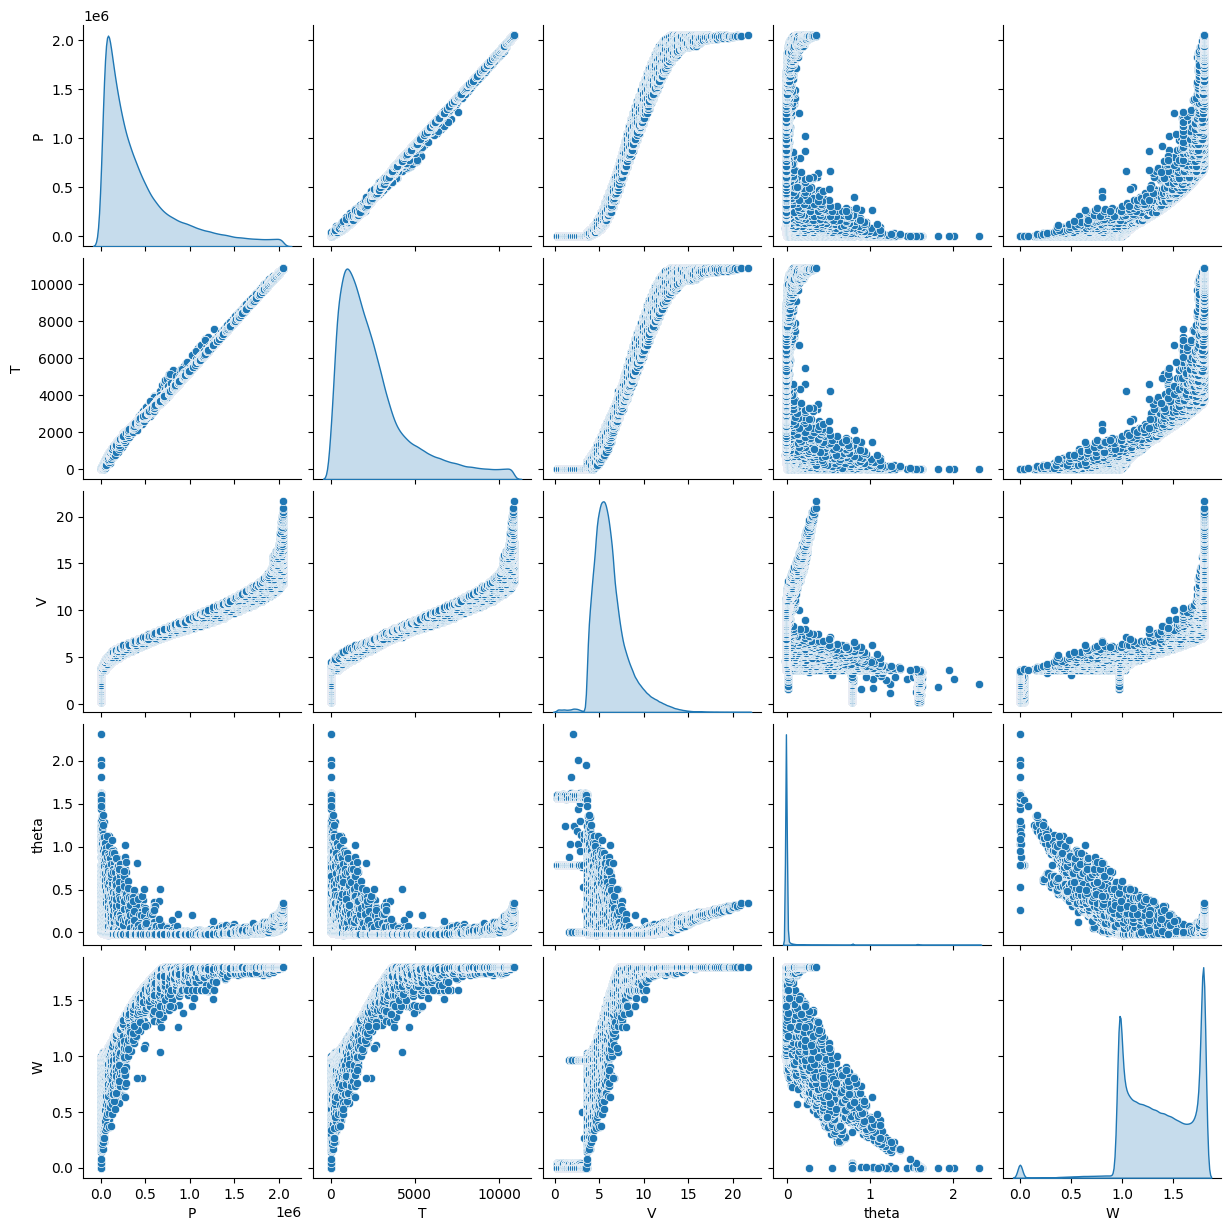

In [46]:
# Inspect the data with the joint distribition of a few pairs of columns from the training set

sns.pairplot(dataset[['P', 'T', 'V', 'theta', 'W']], diag_kind='kde')


In [6]:
# Check overal statistis of each input feature 
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
V,727292.0,6.281493,1.995660,0.230000,4.960000,5.870000,7.090000,2.167000e+01
theta,727292.0,0.002826,0.129452,-0.026704,-0.017453,-0.017279,-0.015708,2.312212e+00
W,727292.0,1.356542,0.329573,0.000000,1.089085,1.346696,1.660855,1.803274e+00
T,727292.0,2619.547843,2241.645819,0.000000,1043.010000,1963.324950,3376.169900,1.087570e+04
P,727292.0,439958.330594,442728.758322,0.000000,121400.000000,281620.000000,596549.992500,2.051870e+06


In [7]:
# Normalization

print(dataset.describe().transpose()[['mean', 'std']])

train_dataset_norm=(train_dataset-dataset.mean())/dataset.std()
test_dataset_norm=(test_dataset-dataset.mean())/dataset.std()

print()
print("Normalized dataset")
print(train_dataset_norm.describe().transpose()[['mean', 'std']])

                mean            std
V           6.281493       1.995660
theta       0.002826       0.129452
W           1.356542       0.329573
T        2619.547843    2241.645819
P      439958.330594  442728.758322

Normalized dataset
           mean       std
V     -0.000640  0.999263
theta  0.000388  1.002013
W     -0.000354  1.000316
T     -0.000550  0.999261
P     -0.000558  0.999263


In [8]:
# Functions to normalize and compute original units from normalized units

T_mean = dataset['T'].mean()
T_std = dataset['T'].std()
W_mean = dataset['W'].mean()
W_std = dataset['W'].std()
P_mean = dataset['P'].mean()
P_std = dataset['P'].std()

def normalize_P(P):
    return (P-P_mean)/P_std
def normalize_T(T):
    return (T-T_mean)/T_std
def normalize_W(W):
    return (W-W_mean)/W_std

def units_P(P):
    return P*P_std + P_mean
def units_T(T):
    return T*T_std + T_mean
def units_W(W):
    return W*W_std + W_mean

In [9]:
# Function to compute torque from P using the physical equation P = g * T * W

def P_fromT(W,T):
    Pturbina = const.gear * W * T
    return Pturbina


========== Training with fraction: 0.1 ==========


/home/alfonso/Dropbox/Work/Investigacion/Calculos/WindTurbines_PINNs/.venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


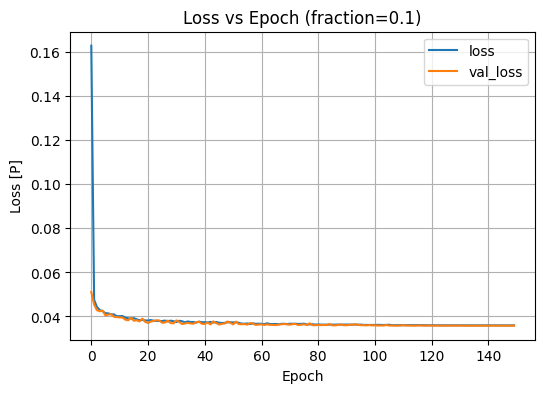

/home/alfonso/Dropbox/Work/Investigacion/Calculos/WindTurbines_PINNs/.venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


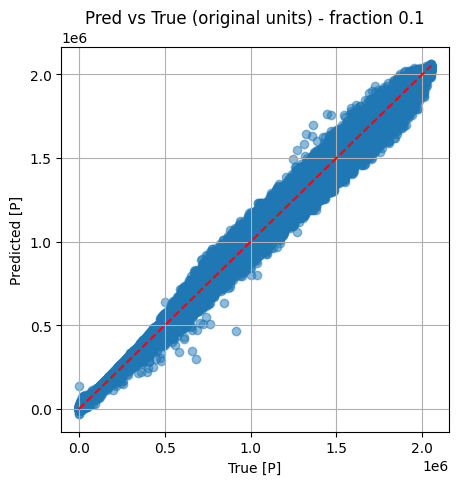

MAE: 3.759571834387807


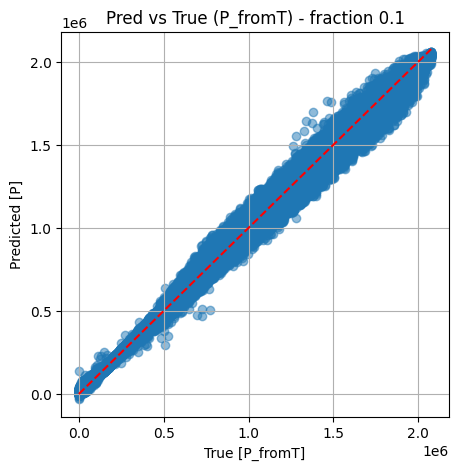

MAE: 3.719350517815552

========== Training with fraction: 0.05 ==========


/home/alfonso/Dropbox/Work/Investigacion/Calculos/WindTurbines_PINNs/.venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


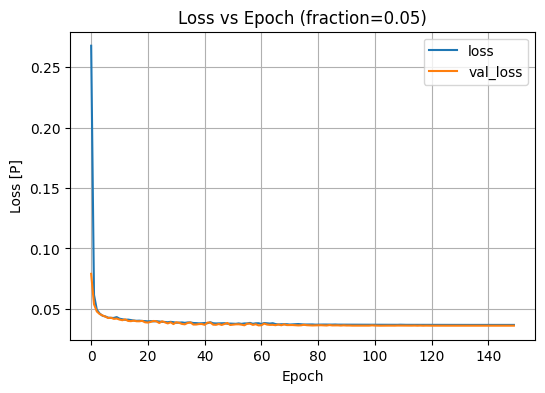

/home/alfonso/Dropbox/Work/Investigacion/Calculos/WindTurbines_PINNs/.venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


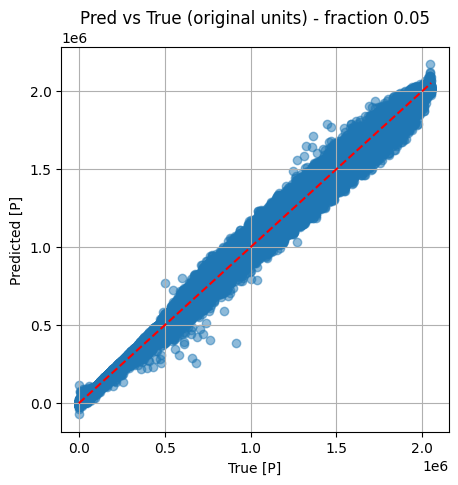

MAE: 3.8183569812574576


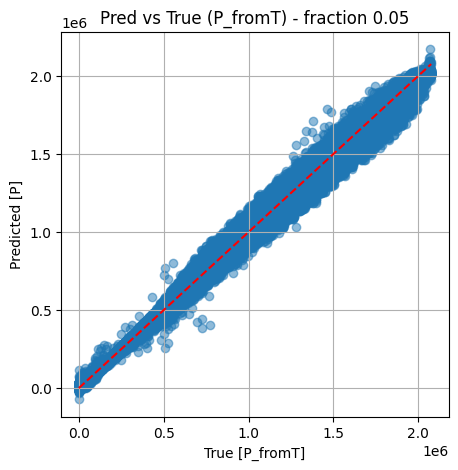

MAE: 3.751275220959935

========== Training with fraction: 0.025 ==========


/home/alfonso/Dropbox/Work/Investigacion/Calculos/WindTurbines_PINNs/.venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


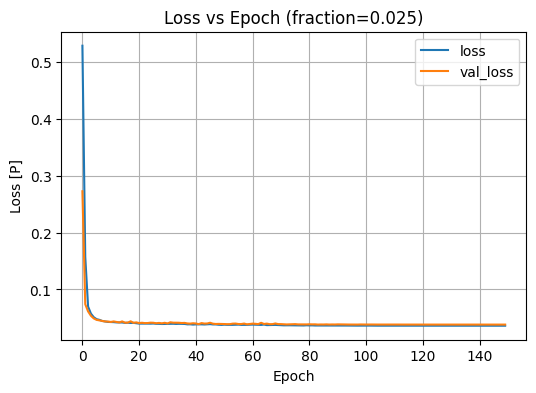

/home/alfonso/Dropbox/Work/Investigacion/Calculos/WindTurbines_PINNs/.venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


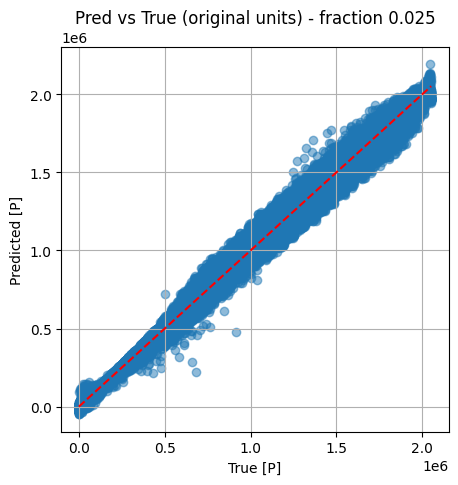

MAE: 3.924298514600749


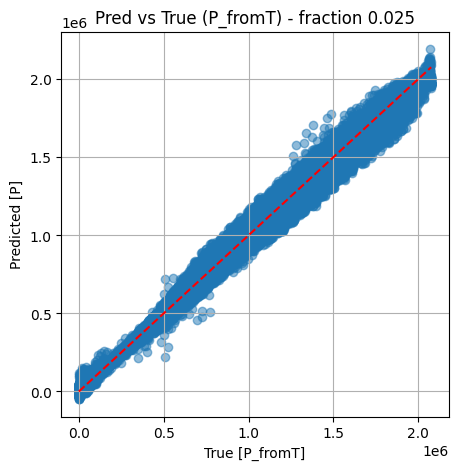

MAE: 3.852451627508259

========== Training with fraction: 0.01 ==========


/home/alfonso/Dropbox/Work/Investigacion/Calculos/WindTurbines_PINNs/.venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


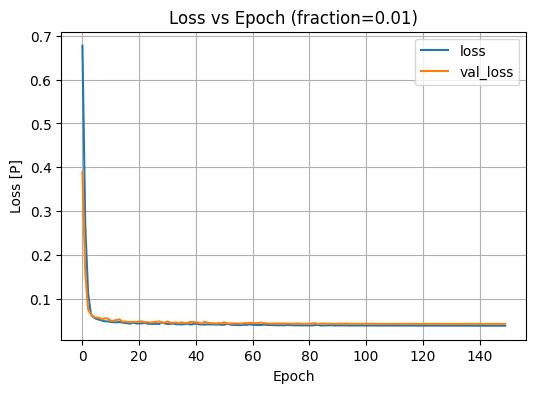

/home/alfonso/Dropbox/Work/Investigacion/Calculos/WindTurbines_PINNs/.venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


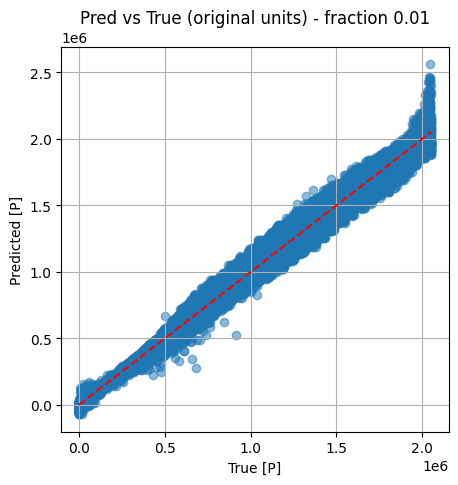

MAE: 4.306454133469898


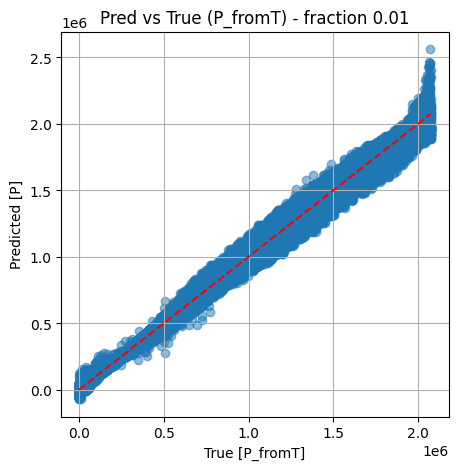

MAE: 4.234761175472812

========== Training with fraction: 0.005 ==========


/home/alfonso/Dropbox/Work/Investigacion/Calculos/WindTurbines_PINNs/.venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


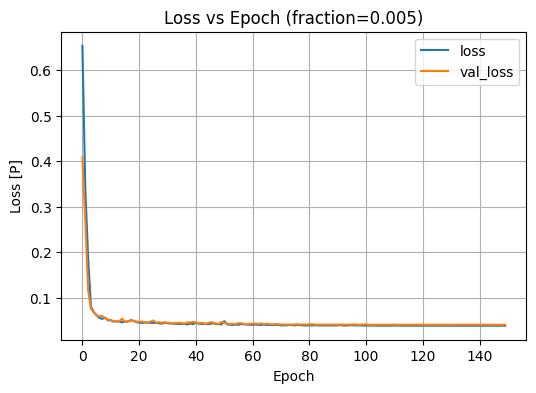

/home/alfonso/Dropbox/Work/Investigacion/Calculos/WindTurbines_PINNs/.venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


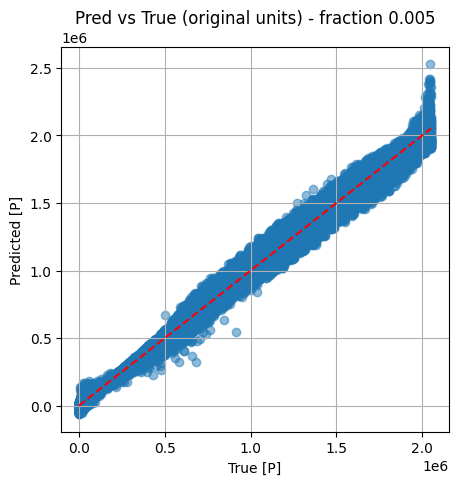

MAE: 4.710945039901112


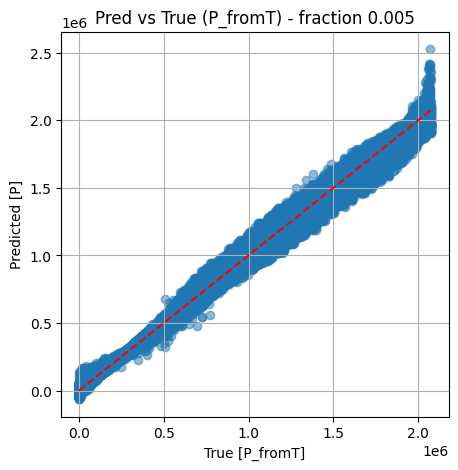

MAE: 4.629895725949113

========== Training with fraction: 0.0025 ==========


/home/alfonso/Dropbox/Work/Investigacion/Calculos/WindTurbines_PINNs/.venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


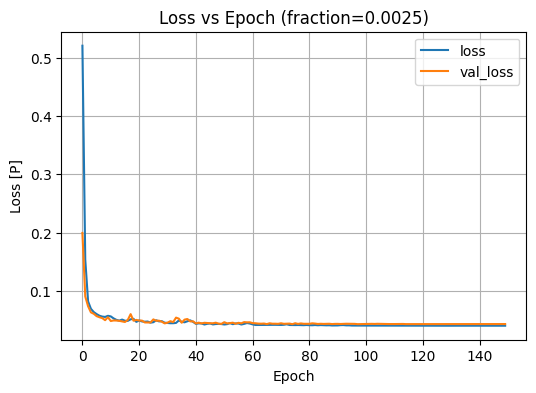

/home/alfonso/Dropbox/Work/Investigacion/Calculos/WindTurbines_PINNs/.venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


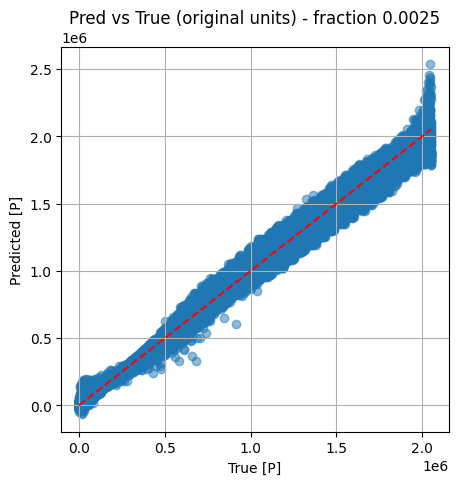

MAE: 5.199899190548705


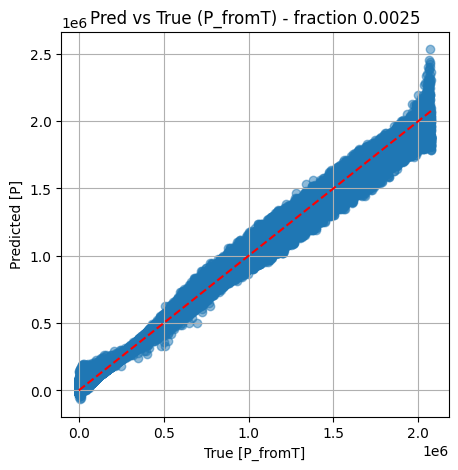

MAE: 5.104436549342912

========== Training with fraction: 0.001 ==========


/home/alfonso/Dropbox/Work/Investigacion/Calculos/WindTurbines_PINNs/.venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


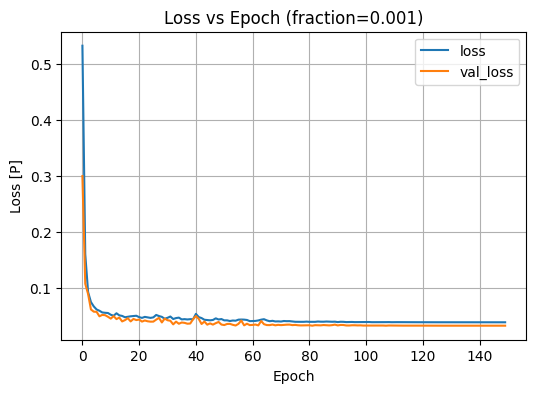

/home/alfonso/Dropbox/Work/Investigacion/Calculos/WindTurbines_PINNs/.venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


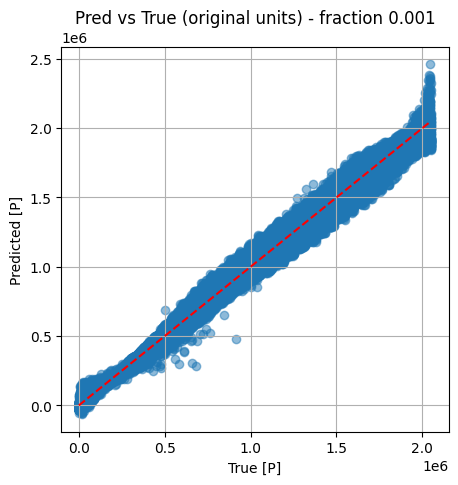

MAE: 5.409166398583682


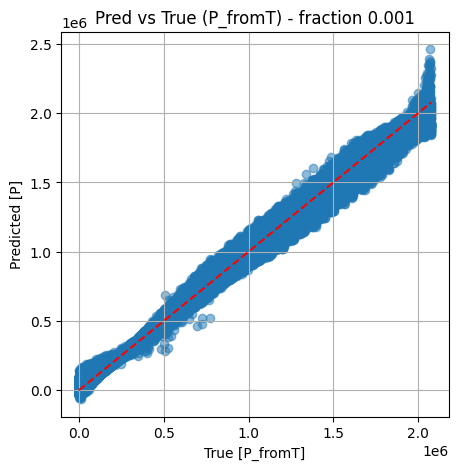

MAE: 5.284788349669004

========== Training with fraction: 0.0005 ==========


/home/alfonso/Dropbox/Work/Investigacion/Calculos/WindTurbines_PINNs/.venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


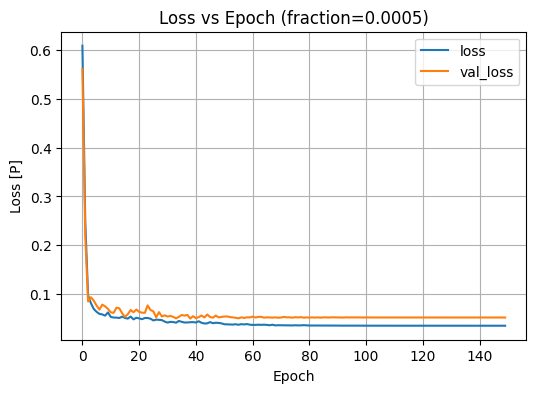

/home/alfonso/Dropbox/Work/Investigacion/Calculos/WindTurbines_PINNs/.venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


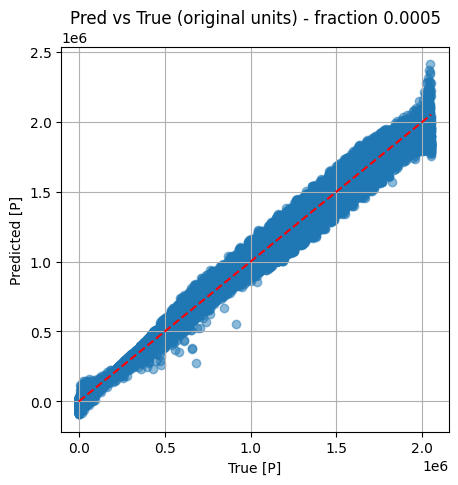

MAE: 5.38397859289337


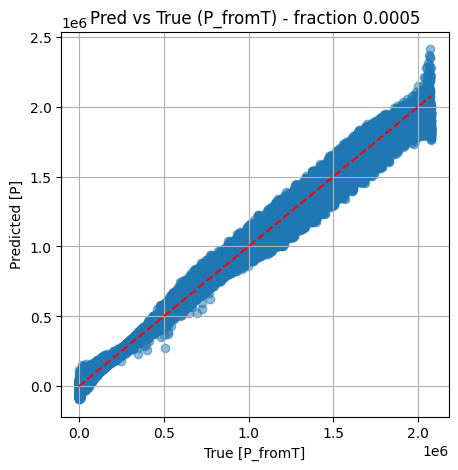

MAE: 5.311025338151818

========== Training with fraction: 0.00025 ==========


/home/alfonso/Dropbox/Work/Investigacion/Calculos/WindTurbines_PINNs/.venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


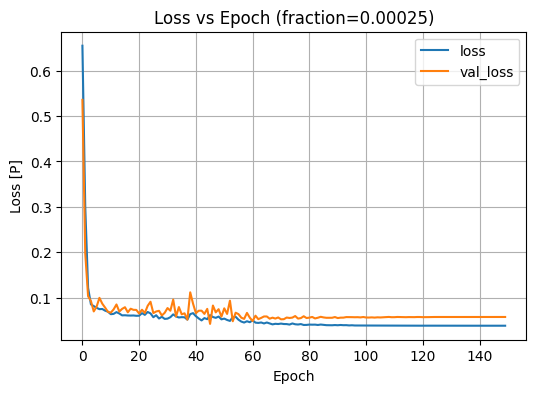

/home/alfonso/Dropbox/Work/Investigacion/Calculos/WindTurbines_PINNs/.venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


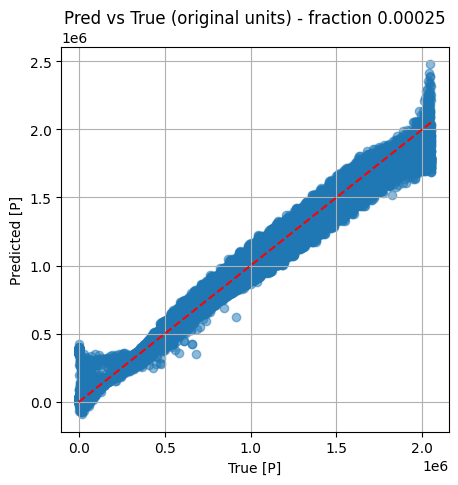

MAE: 6.136384674177093


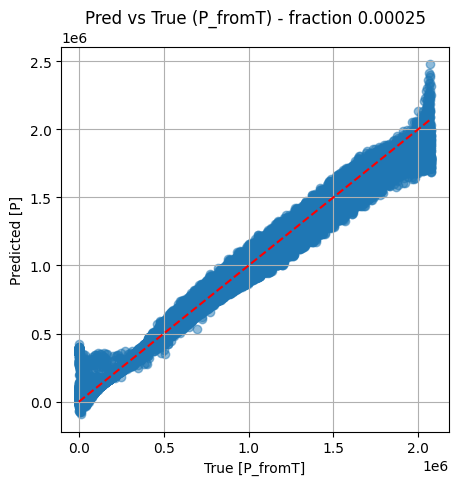

MAE: 5.946871510056127

========== Training with fraction: 0.0001 ==========


/home/alfonso/Dropbox/Work/Investigacion/Calculos/WindTurbines_PINNs/.venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


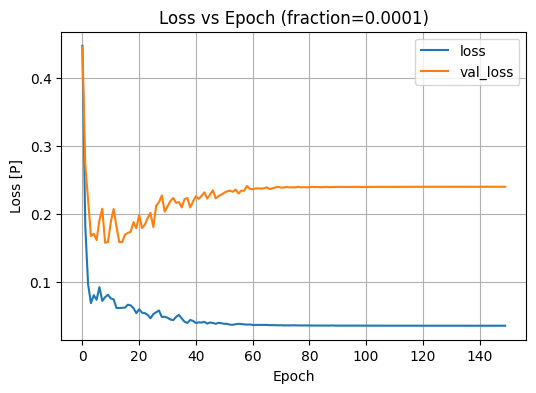

/home/alfonso/Dropbox/Work/Investigacion/Calculos/WindTurbines_PINNs/.venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


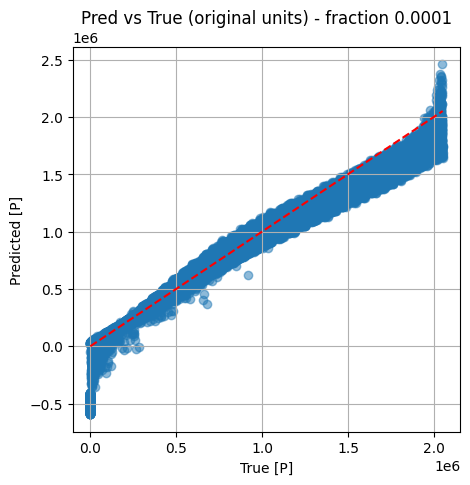

MAE: 8.925316191691122


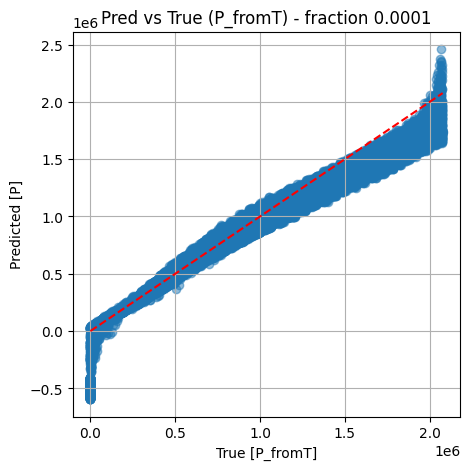

MAE: 8.033038175605386


In [14]:
# Training & Evaluation Loop

fractions = [0.1, 0.05, 0.025, 0.01, 0.005, 0.0025, 0.001, 0.0005, 0.00025, 0.0001]

# Arrays to store evaluation metrics
mae_p_original_units = []
rmse_p_original_units = []
mape_p_original_units = []
r2_p_original_units = []

mae_p_fromT = []
rmse_p_fromT = []
mape_p_fromT = []
r2_p_fromT = []

fraction_values = []
ndata_values = []

# Build the Keras model
def build_final_model():
    input_layer = keras.Input(shape=(3,))
    x = keras.layers.Dense(64, activation='relu')(input_layer)
    x = keras.layers.Dense(64, activation='relu')(x)
    output = keras.layers.Dense(1)(x)
    model = keras.Model(inputs=input_layer, outputs=output)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_absolute_error'
    )
    return model

# Loop over different data fractions
for fraction in fractions:
    print(f"\n========== Training with fraction: {fraction} ==========")

    N_total = len(train_dataset_norm)
    N_data = int(fraction * N_total)

    # Prepare full dataset
    XX_all = train_dataset_norm[['V', 'theta', 'W', 'T']].to_numpy()
    YY_all = train_dataset_norm['P'].to_numpy()
    X_all = XX_all[:, :3]
    Wt_all = XX_all[:, 2]
    Torque_all = XX_all[:, 3]
    PT_all = normalize_P(P_fromT(units_W(Wt_all), units_T(Torque_all)))

    # Select random training subset
    np.random.seed(42)
    indices = np.arange(N_total)
    data_indices = np.random.choice(indices, size=N_data, replace=False)

    X_train = X_all[data_indices]
    Y_train = YY_all[data_indices]

    #batch_size = max(32, int(0.05 * len(X_train)))
    #batch_size = int(0.05 * len(X_train))
    if int(0.05 * len(X_train)) > 512:
        batch_size = 512
    else: 
        batch_size = int(0.05 * len(X_train))
    model = build_final_model()

    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6
    )

    # Train the model
    history = model.fit(
        X_train, Y_train,
        epochs=150,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[reduce_lr],
        verbose=0
    )

    # Plot loss vs. epoch
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss [P]')
    plt.title(f'Loss vs Epoch (fraction={fraction})')
    plt.legend()
    plt.grid(True)
    plt.show()

    # === Evaluation on P (original units) ===
    X_test = test_dataset_norm[['V', 'theta', 'W']].to_numpy()
    Y_test = test_dataset_norm['P'].to_numpy()
    y_true = Y_test[:]
    y_pred = model.predict(X_test)

    # Denormalize predictions and true values
    x_mean = np.nanmean(dataset, axis=0)
    x_std = np.nanstd(dataset, axis=0)
    y_pred = y_pred * x_std[4] + x_mean[4]
    y_true = y_true * x_std[4] + x_mean[4]

    # Scatter plot of predictions vs true
    plt.figure(figsize=(5, 5))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('True [P]')
    plt.ylabel('Predicted [P]')
    plt.title(f'Pred vs True (original units) - fraction {fraction}')
    plt.grid(True)
    plt.show()

    # Filter high-power samples for MAPE
    p_cutoff = 25000
    y_pred_nonzero = y_pred[abs(y_true) > p_cutoff]
    y_true_nonzero = y_true[abs(y_true) > p_cutoff]

    # Compute metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mape = mean_absolute_percentage_error(y_true_nonzero, y_pred_nonzero) * 100
    r2 = r2_score(y_true, y_pred)
    print("MAE: "+str(mape))

    # Store results
    mae_p_original_units.append(mae)
    rmse_p_original_units.append(rmse)
    mape_p_original_units.append(mape)
    r2_p_original_units.append(r2)

    # === Evaluation on P_fromT ===
    W_true = test_dataset['W'].to_numpy()
    T_true = test_dataset['T'].to_numpy()
    y_true = const.gear * T_true * W_true
    y_pred = model.predict(X_test)
    y_pred = y_pred * x_std[4] + x_mean[4]

    plt.figure(figsize=(5, 5))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('True [P_fromT]')
    plt.ylabel('Predicted [P]')
    plt.title(f'Pred vs True (P_fromT) - fraction {fraction}')
    plt.grid(True)
    plt.show()

    y_pred_nonzero = y_pred[abs(y_true) > p_cutoff]
    y_true_nonzero = y_true[abs(y_true) > p_cutoff]

    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mape = mean_absolute_percentage_error(y_true_nonzero, y_pred_nonzero) * 100
    r2 = r2_score(y_true, y_pred)
    print("MAE: "+str(mape))

    mae_p_fromT.append(mae)
    rmse_p_fromT.append(rmse)
    mape_p_fromT.append(mape)
    r2_p_fromT.append(r2)

    # Track fraction and number of samples
    fraction_values.append(fraction)
    ndata_values.append(N_data)

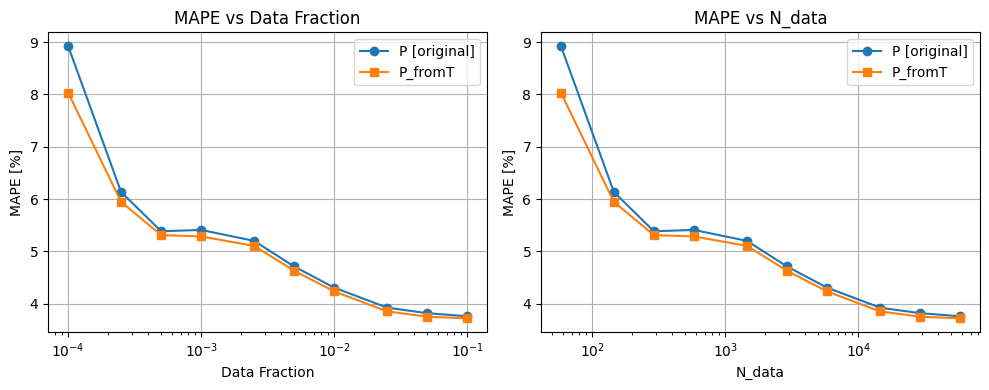

In [15]:
# Plotting MAPE vs Fraction and N_data

plt.figure(figsize=(10, 4))

# Plot MAPE vs Fraction (log scale)
plt.subplot(1, 2, 1)
plt.plot(fraction_values, mape_p_original_units, marker='o', label='P [original]')
plt.plot(fraction_values, mape_p_fromT, marker='s', label='P_fromT')
plt.xscale('log')
plt.xlabel('Data Fraction')
plt.ylabel('MAPE [%]')
plt.title('MAPE vs Data Fraction')
plt.grid(True)
plt.legend()

# Plot MAPE vs N_data (log scale)
plt.subplot(1, 2, 2)
plt.plot(ndata_values, mape_p_original_units, marker='o', label='P [original]')
plt.plot(ndata_values, mape_p_fromT, marker='s', label='P_fromT')
plt.xscale('log')
plt.xlabel('N_data')
plt.ylabel('MAPE [%]')
plt.title('MAPE vs N_data')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


========== Fraction: 0.1 ==========


/home/alfonso/Dropbox/Work/Investigacion/Calculos/WindTurbines_PINNs/.venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


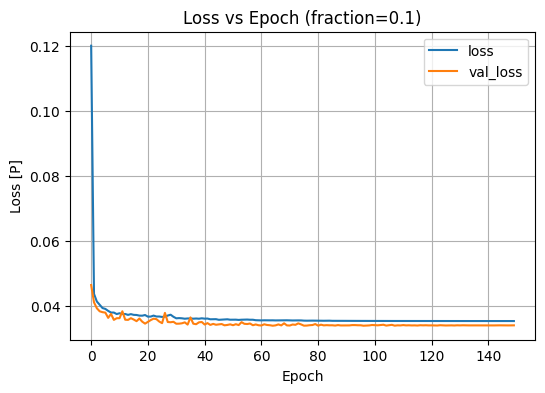

/home/alfonso/Dropbox/Work/Investigacion/Calculos/WindTurbines_PINNs/.venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


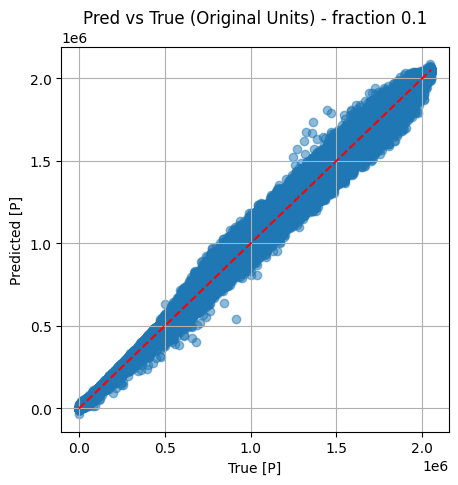

MAE: 3.794196711194078


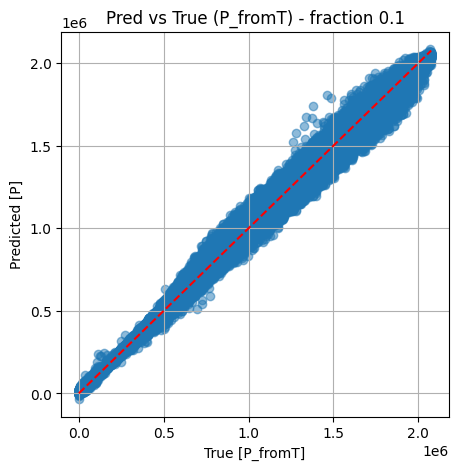

MAE: 3.5804539040315273

========== Fraction: 0.05 ==========


/home/alfonso/Dropbox/Work/Investigacion/Calculos/WindTurbines_PINNs/.venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


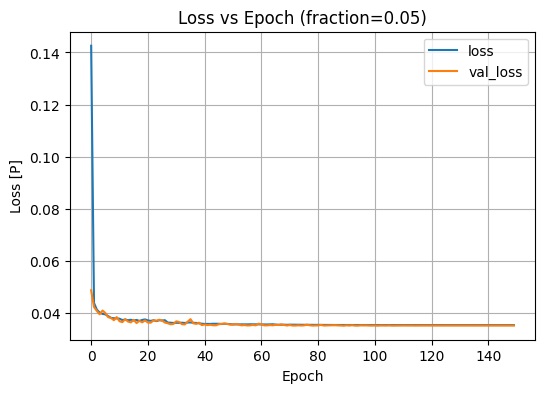

/home/alfonso/Dropbox/Work/Investigacion/Calculos/WindTurbines_PINNs/.venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


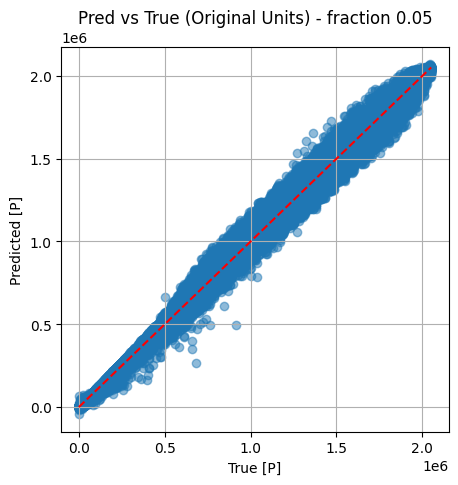

MAE: 3.9076375228855444


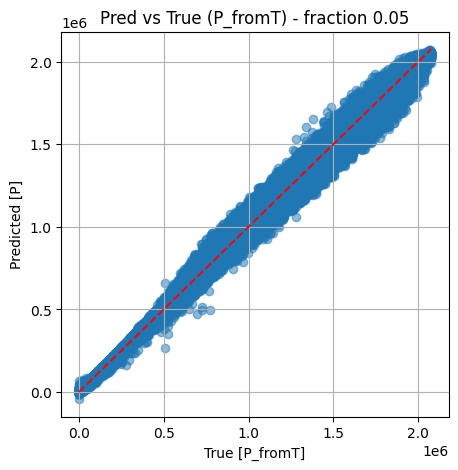

MAE: 3.5229316982355763

========== Fraction: 0.025 ==========


/home/alfonso/Dropbox/Work/Investigacion/Calculos/WindTurbines_PINNs/.venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


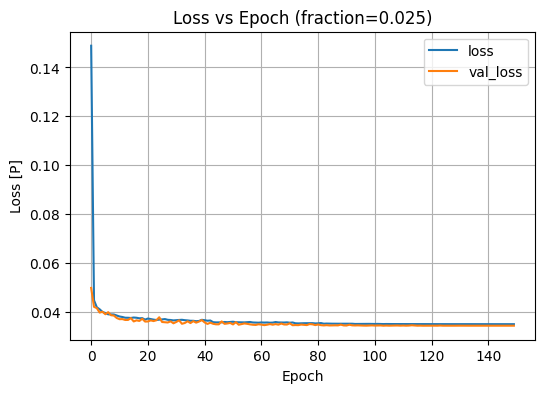

/home/alfonso/Dropbox/Work/Investigacion/Calculos/WindTurbines_PINNs/.venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


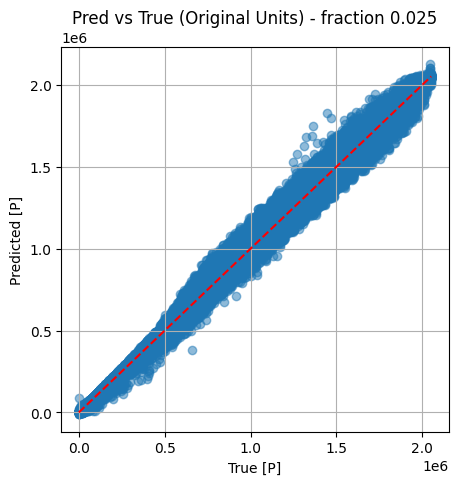

MAE: 3.9519019034981264


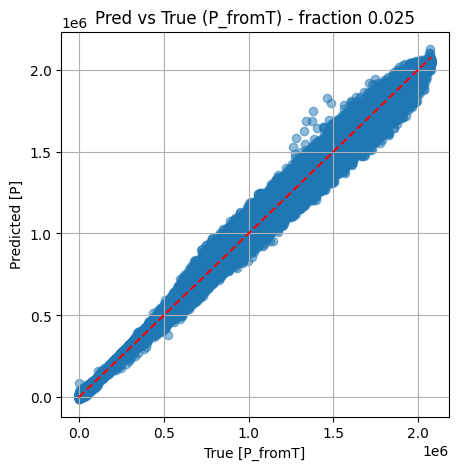

MAE: 3.479953303564635

========== Fraction: 0.01 ==========


/home/alfonso/Dropbox/Work/Investigacion/Calculos/WindTurbines_PINNs/.venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


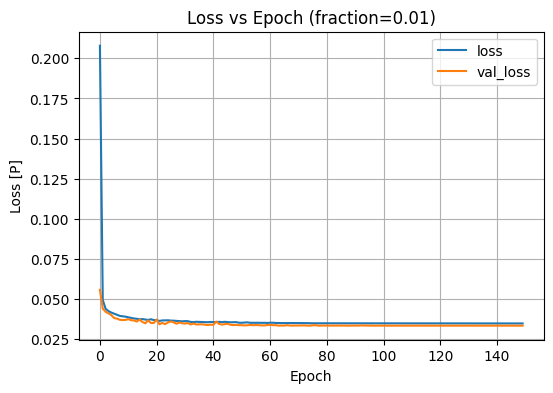

/home/alfonso/Dropbox/Work/Investigacion/Calculos/WindTurbines_PINNs/.venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


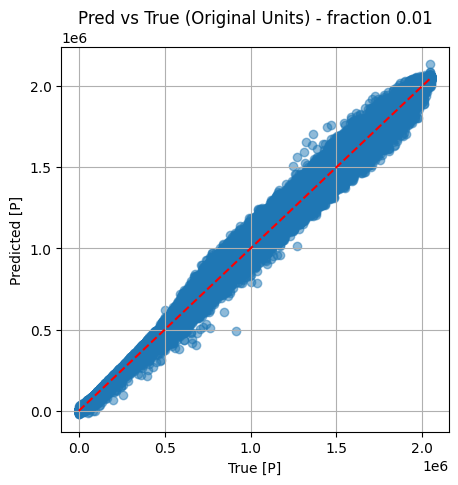

MAE: 3.9900565424716046


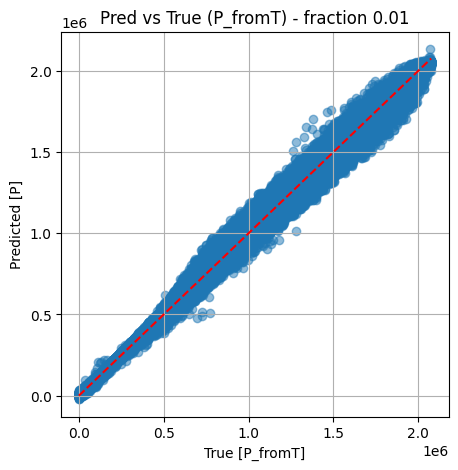

MAE: 3.476450117816813

========== Fraction: 0.005 ==========


/home/alfonso/Dropbox/Work/Investigacion/Calculos/WindTurbines_PINNs/.venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


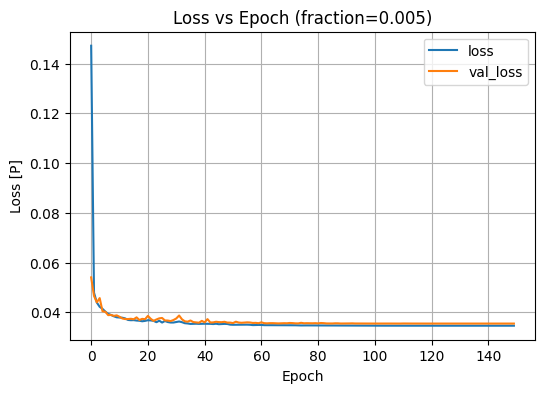

/home/alfonso/Dropbox/Work/Investigacion/Calculos/WindTurbines_PINNs/.venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


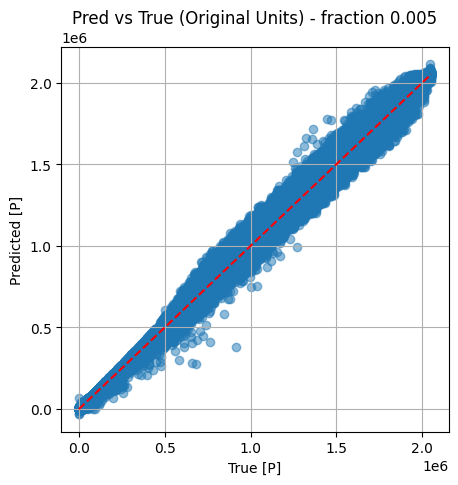

MAE: 4.029923700835239


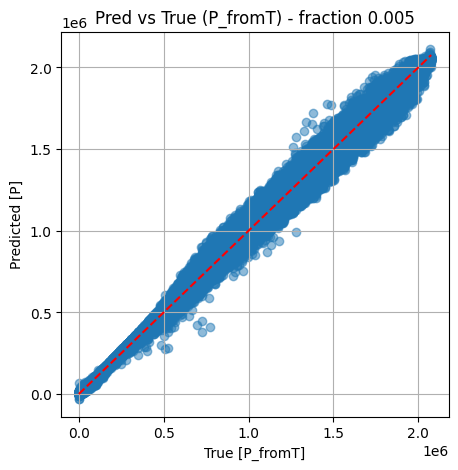

MAE: 3.4854021688767207

========== Fraction: 0.0025 ==========


/home/alfonso/Dropbox/Work/Investigacion/Calculos/WindTurbines_PINNs/.venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


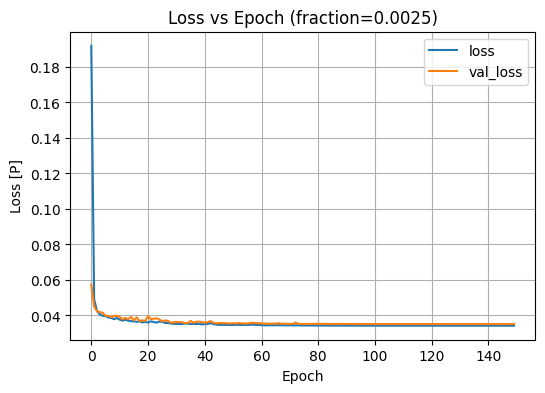

/home/alfonso/Dropbox/Work/Investigacion/Calculos/WindTurbines_PINNs/.venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


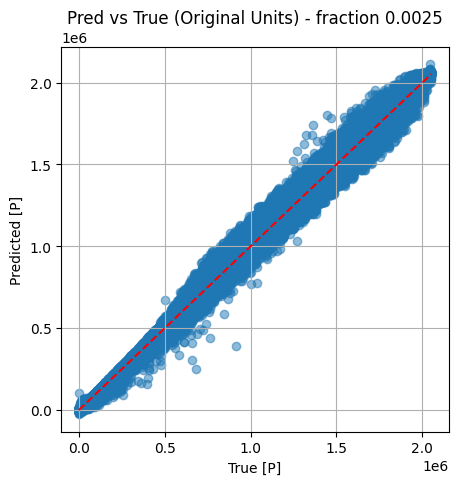

MAE: 4.024775601030006


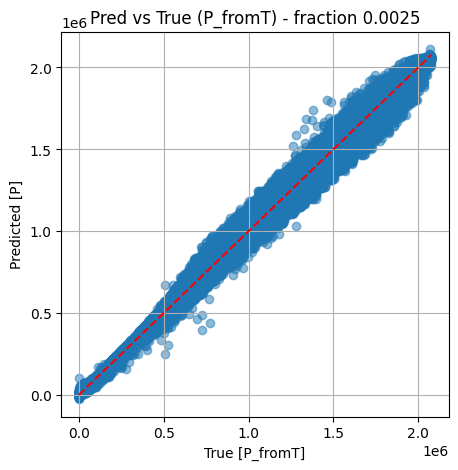

MAE: 3.499799232850413

========== Fraction: 0.001 ==========


/home/alfonso/Dropbox/Work/Investigacion/Calculos/WindTurbines_PINNs/.venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


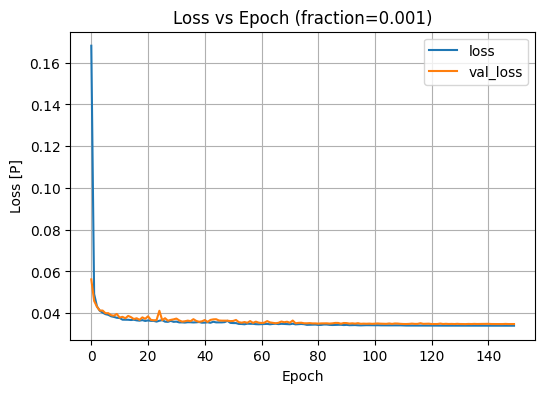

/home/alfonso/Dropbox/Work/Investigacion/Calculos/WindTurbines_PINNs/.venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


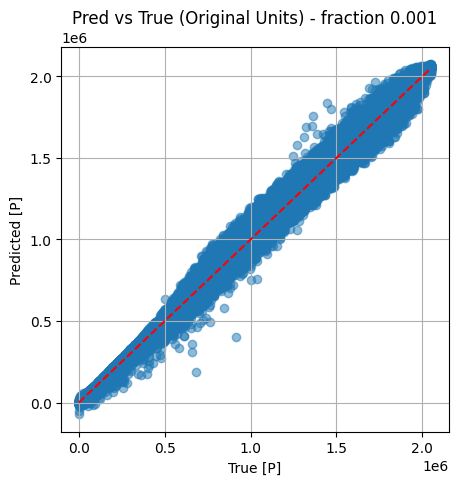

MAE: 4.043358756327425


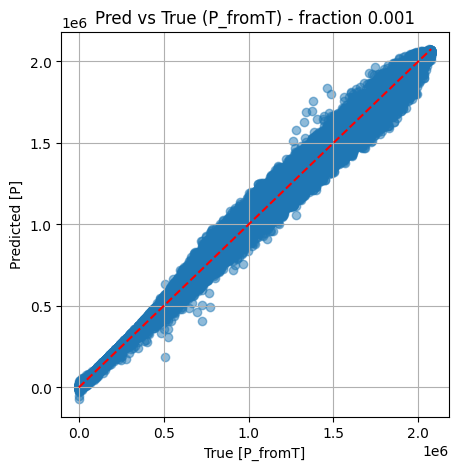

MAE: 3.480340242299998

========== Fraction: 0.0005 ==========


/home/alfonso/Dropbox/Work/Investigacion/Calculos/WindTurbines_PINNs/.venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


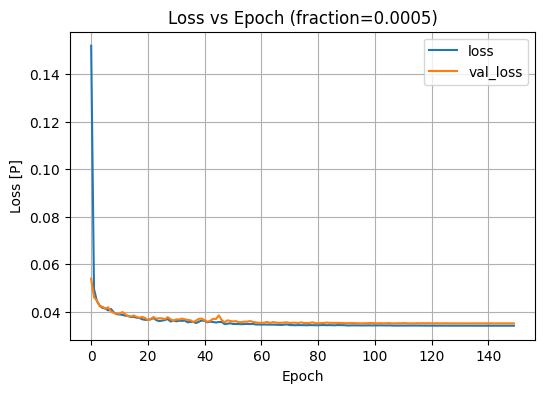

/home/alfonso/Dropbox/Work/Investigacion/Calculos/WindTurbines_PINNs/.venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


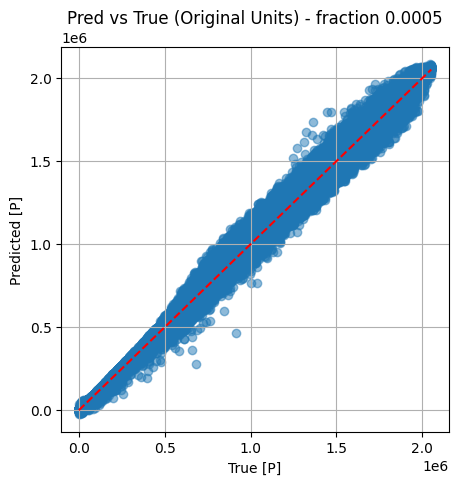

MAE: 4.016732667370385


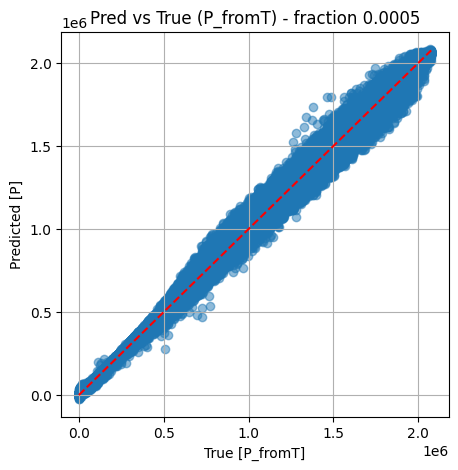

MAE: 3.489704153622105

========== Fraction: 0.00025 ==========


/home/alfonso/Dropbox/Work/Investigacion/Calculos/WindTurbines_PINNs/.venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


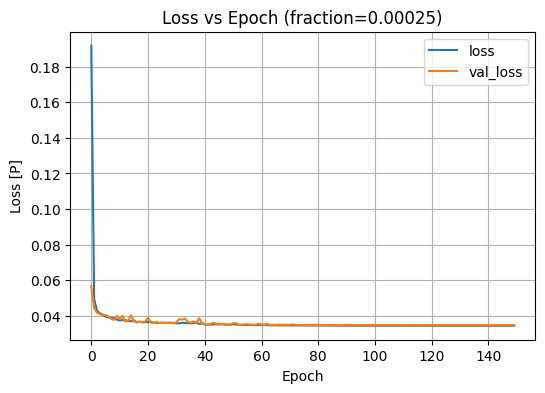

/home/alfonso/Dropbox/Work/Investigacion/Calculos/WindTurbines_PINNs/.venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


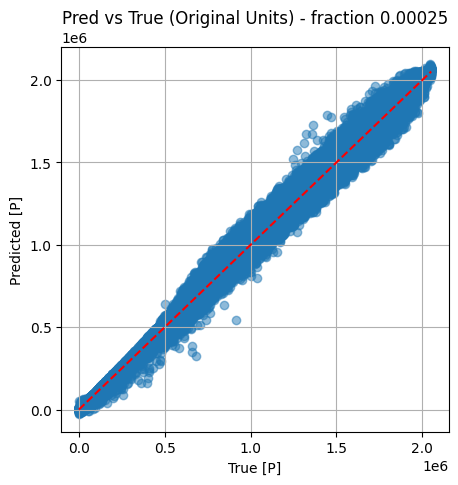

MAE: 4.008902559717295


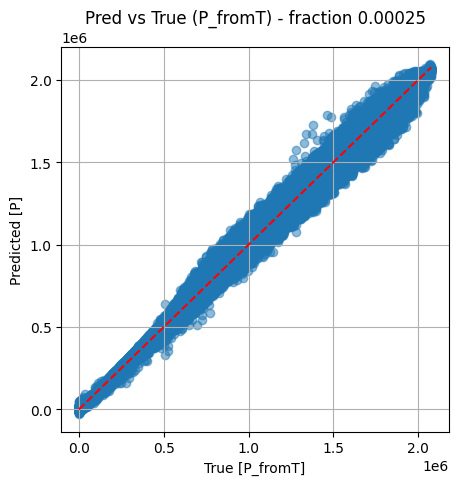

MAE: 3.4713957413878656

========== Fraction: 0.0001 ==========


/home/alfonso/Dropbox/Work/Investigacion/Calculos/WindTurbines_PINNs/.venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


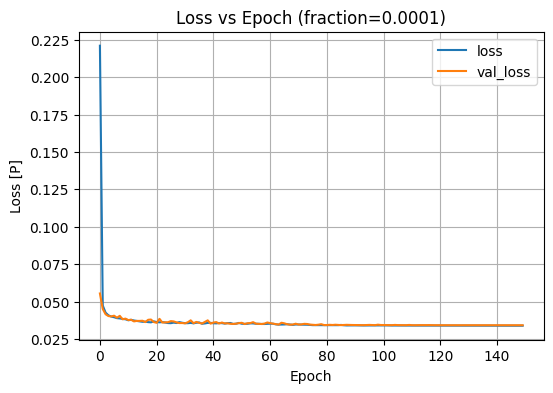

/home/alfonso/Dropbox/Work/Investigacion/Calculos/WindTurbines_PINNs/.venv/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


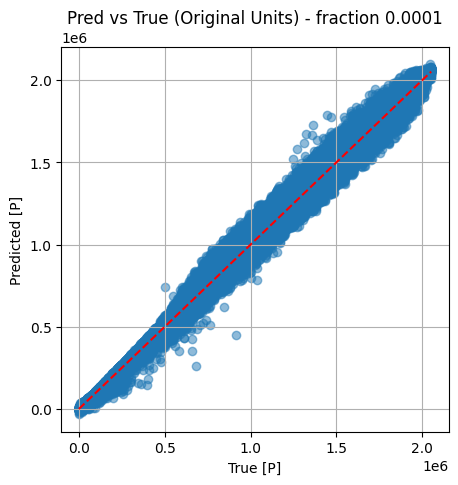

MAE: 4.009611253683087


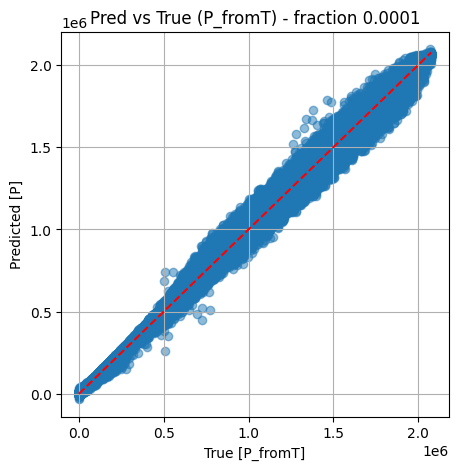

MAE: 3.467636993695962


In [19]:
# Training Loop with N_phys = 10% of Total + Plots

# Define model
def build_final_model():
    input_layer = keras.Input(shape=(3,))
    x = keras.layers.Dense(64, activation='relu')(input_layer)
    x = keras.layers.Dense(64, activation='relu')(x)
    output = keras.layers.Dense(1)(x)
    model = keras.Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mean_absolute_error')
    return model

# Storage arrays
mae_p_orig_phys = []
rmse_p_orig_phys = []
mape_p_orig_phys = []
r2_p_orig_phys = []

mae_pT_phys = []
rmse_pT_phys = []
mape_pT_phys = []
r2_pT_phys = []

fraction_phys = []
ndata_phys = []

fractions = [0.1, 0.05, 0.025, 0.01, 0.005, 0.0025, 0.001, 0.0005, 0.00025, 0.0001]

for fraction in fractions:
    print(f"\n========== Fraction: {fraction} ==========")

    N_total = len(train_dataset_norm)
    N_data = int(fraction * N_total)
    N_phys = int(0.1 * N_total)

    # Prepare datasets
    XX_all = train_dataset_norm[['V', 'theta', 'W', 'T']].to_numpy()
    YY_all = train_dataset_norm['P'].to_numpy()
    X_all = XX_all[:, :3]
    Wt_all = XX_all[:, 2]
    Torque_all = XX_all[:, 3]
    PT_all = normalize_P(P_fromT(units_W(Wt_all), units_T(Torque_all)))

    np.random.seed(42)
    indices = np.arange(N_total)
    data_indices = np.random.choice(indices, size=N_data, replace=False)
    remaining_indices = np.setdiff1d(indices, data_indices)
    physics_indices = np.random.choice(remaining_indices, size=N_phys, replace=False)

    X_data = X_all[data_indices]
    Y_data = YY_all[data_indices]
    X_phys = X_all[physics_indices]
    Y_phys = PT_all[physics_indices]

    X_train = np.concatenate([X_data, X_phys], axis=0)
    Y_train = np.concatenate([Y_data, Y_phys], axis=0)

    batch_size = min(512, int(0.05 * len(X_train)))

    model = build_final_model()
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

    history = model.fit(
        X_train, Y_train,
        epochs=150,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[reduce_lr],
        verbose=0
    )

    # --- Plot Loss ---
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss [P]')
    plt.title(f'Loss vs Epoch (fraction={fraction})')
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Evaluation: P original ---
    X_test = test_dataset_norm[['V','theta','W']].to_numpy()
    Y_test = test_dataset_norm['P'].to_numpy()
    y_pred = model.predict(X_test)

    x_mean = np.nanmean(dataset, axis=0)
    x_std = np.nanstd(dataset, axis=0)
    y_pred_orig = y_pred * x_std[4] + x_mean[4]
    y_true_orig = Y_test * x_std[4] + x_mean[4]

    plt.figure(figsize=(5, 5))
    plt.scatter(y_true_orig, y_pred_orig, alpha=0.5)
    plt.plot([y_true_orig.min(), y_true_orig.max()],
             [y_true_orig.min(), y_true_orig.max()], 'r--')
    plt.xlabel('True [P]')
    plt.ylabel('Predicted [P]')
    plt.title(f'Pred vs True (Original Units) - fraction {fraction}')
    plt.grid(True)
    plt.show()

    # Compute metrics
    p_cutoff = 25000
    y_pred_nz = y_pred_orig[abs(y_true_orig) > p_cutoff]
    y_true_nz = y_true_orig[abs(y_true_orig) > p_cutoff]

    mae = mean_absolute_error(y_true_orig, y_pred_orig)
    rmse = mean_squared_error(y_true_orig, y_pred_orig, squared=False)
    mape = mean_absolute_percentage_error(y_true_nz, y_pred_nz) * 100
    r2 = r2_score(y_true_orig, y_pred_orig)
    print("MAE: "+str(mape))

    mae_p_orig_phys.append(mae)
    rmse_p_orig_phys.append(rmse)
    mape_p_orig_phys.append(mape)
    r2_p_orig_phys.append(r2)

    # --- Evaluation: P_fromT ---
    W_true = test_dataset['W'].to_numpy()
    T_true = test_dataset['T'].to_numpy()
    y_true_phys = const.gear * T_true * W_true
    y_pred_phys = y_pred * x_std[4] + x_mean[4]

    plt.figure(figsize=(5, 5))
    plt.scatter(y_true_phys, y_pred_phys, alpha=0.5)
    plt.plot([y_true_phys.min(), y_true_phys.max()],
             [y_true_phys.min(), y_true_phys.max()], 'r--')
    plt.xlabel('True [P_fromT]')
    plt.ylabel('Predicted [P]')
    plt.title(f'Pred vs True (P_fromT) - fraction {fraction}')
    plt.grid(True)
    plt.show()

    y_pred_nz = y_pred_phys[abs(y_true_phys) > p_cutoff]
    y_true_nz = y_true_phys[abs(y_true_phys) > p_cutoff]

    mae = mean_absolute_error(y_true_phys, y_pred_phys)
    rmse = mean_squared_error(y_true_phys, y_pred_phys, squared=False)
    mape = mean_absolute_percentage_error(y_true_nz, y_pred_nz) * 100
    r2 = r2_score(y_true_phys, y_pred_phys)
    print("MAE: "+str(mape))

    mae_pT_phys.append(mae)
    rmse_pT_phys.append(rmse)
    mape_pT_phys.append(mape)
    r2_pT_phys.append(r2)

    fraction_phys.append(fraction)
    ndata_phys.append(N_data)

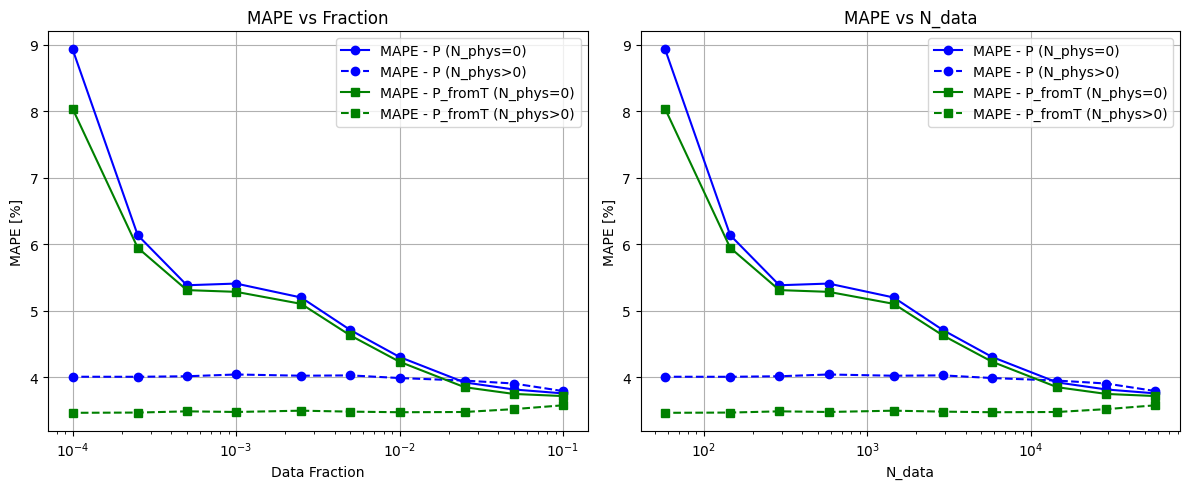

In [20]:
# Plot MAPE vs fraction and N_data, comparing N_phys = 0 and N_phys ≠ 0

plt.figure(figsize=(12, 5))

# --- Plot vs fraction ---
plt.subplot(1, 2, 1)
plt.plot(fraction_values, mape_p_original_units, 'o-', color='blue', label='MAPE - P (N_phys=0)')
plt.plot(fraction_phys, mape_p_orig_phys, 'o--', color='blue', label='MAPE - P (N_phys>0)')

plt.plot(fraction_values, mape_p_fromT, 's-', color='green', label='MAPE - P_fromT (N_phys=0)')
plt.plot(fraction_phys, mape_pT_phys, 's--', color='green', label='MAPE - P_fromT (N_phys>0)')

plt.xscale('log')
plt.xlabel('Data Fraction')
plt.ylabel('MAPE [%]')
plt.title('MAPE vs Fraction')
plt.grid(True)
plt.legend()

# --- Plot vs N_data ---
plt.subplot(1, 2, 2)
plt.plot(ndata_values, mape_p_original_units, 'o-', color='blue', label='MAPE - P (N_phys=0)')
plt.plot(ndata_phys, mape_p_orig_phys, 'o--', color='blue', label='MAPE - P (N_phys>0)')

plt.plot(ndata_values, mape_p_fromT, 's-', color='green', label='MAPE - P_fromT (N_phys=0)')
plt.plot(ndata_phys, mape_pT_phys, 's--', color='green', label='MAPE - P_fromT (N_phys>0)')

plt.xscale('log')
plt.xlabel('N_data')
plt.ylabel('MAPE [%]')
plt.title('MAPE vs N_data')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

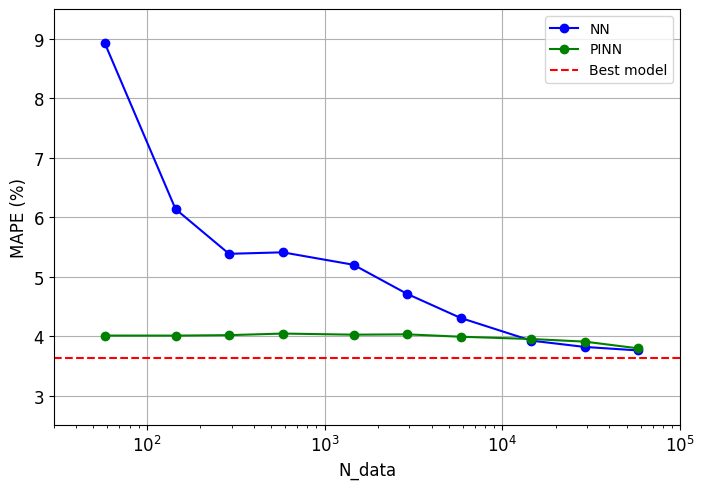

In [55]:
plt.figure(figsize=(7, 5))

# Plot MAPE for NN (N_phys = 0)
plt.plot(ndata_values, mape_p_original_units, 'o-', color='blue', label='NN')

# Plot MAPE for PINN (N_phys > 0)
plt.plot(ndata_phys, mape_p_orig_phys, 'o-', color='green', label='PINN')

# Reference line for best model
plt.axhline(y=3.63, color='red', linestyle='--', label='Best model')

# Fontsize of tics
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Fontsize of legend
plt.legend(fontsize=12)

plt.xscale('log')
plt.xlabel('N_data',fontsize=12)
plt.ylabel('MAPE (%)',fontsize=12)
#plt.title('MAPE vs N_data')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.ylim([2.5,9.5])
plt.xlim([3e1,1e5])
plt.show()